# APIM ❤️ OpenAI

## Backend pool Load Balancing lab
![flow](images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/en-us/azure/api-management/backends?tabs=bicep) to either a list of Azure OpenAI endpoints or mock servers.

Notes:
- The backend pool uses round-robin by default
- But priority and weight based routing are also supported: Adjust the `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered
- Use the mock servers by cleaning the `openai_resources` variable and simulate custom behavior by changing the code in the [app.py](../../tools/mock-server/app.py) file 

### Result
![result](images/result.png)

<a id='2'></a>
### 2️⃣ Create deployment using Terraform

This lab uses Terraform to declaratively define all the resources that will be deployed. Change the [variables.tf](variables.tf) directly to try different configurations.

In [43]:
! terraform init
! terraform apply -auto-approve

Initializing the backend...
Initializing provider plugins...
- Reusing previous version of azure/azapi from the dependency lock file
- Reusing previous version of hashicorp/azurerm from the dependency lock file
- Using previously-installed azure/azapi v2.1.0
- Using previously-installed hashicorp/azurerm v4.14.0
Terraform has made some changes to the provider dependency selections recorded
in the .terraform.lock.hcl file. Review those changes and commit them to your
version control system if they represent changes you intended to make.

Terraform has been successfully initialized!

You may now begin working with Terraform. Try running "terraform plan" to see
any changes that are required for your infrastructure. All Terraform commands
should now work.

If you ever set or change modules or backend configuration for Terraform,
rerun this command to reinitialize your working directory. If you forget, other
commands will detect it and remind you to do so if necessary.
azurerm_resource_grou

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [44]:
apim_resource_gateway_url = ! terraform output -raw apim_resource_gateway_url
apim_resource_gateway_url = apim_resource_gateway_url.n
apim_subscription_key = ! terraform output -raw apim_subscription_key
apim_subscription_key = apim_subscription_key.n
openai_api_version = "2024-10-21"
openai_model_name = "gpt-4o"
openai_deployment_name = "gpt-4o"

print("👉🏻 APIM Resource Gateway URL: ", apim_resource_gateway_url)
print("👉🏻 APIM Subscription Key: ", apim_subscription_key)

👉🏻 APIM Resource Gateway URL:  https://apim-external-300-test.azure-api.net
👉🏻 APIM Subscription Key:  7a8a47c340754f8e82cfbb9f20a618a6


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

In [45]:
import time
import os
import json
import datetime
import requests

runs = 20
sleep_time_ms = 200
url = apim_resource_gateway_url + "/openai/deployments/" + openai_deployment_name + "/chat/completions?api-version=" + openai_api_version
api_runs = []

for i in range(runs):
    print("▶️ Run:", i+1, "/", runs)
    

    messages={"messages":[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]}

    start_time = time.time()
    response = requests.post(url, headers = {'api-key':apim_subscription_key}, json = messages)
    response_time = time.time() - start_time
    
    print(f"⌚ {response_time:.2f} seconds")
    # Check the response status code and apply formatting
    if 200 <= response.status_code < 300:
        status_code_str = '\x1b[1;32m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and green
    elif response.status_code >= 400:
        status_code_str = '\x1b[1;31m' + str(response.status_code) + " - " + response.reason + '\x1b[0m'  # Bold and red
    else:
        status_code_str = str(response.status_code)  # No formatting

    # Print the response status with the appropriate formatting
    print("Response status:", status_code_str)
    
    print("Response headers:", response.headers)
    
    if "x-ms-region" in response.headers:
        print("x-ms-region:", '\x1b[1;31m'+response.headers.get("x-ms-region")+'\x1b[0m') # this header is useful to determine the region of the backend that served the request
        api_runs.append((response_time, response.headers.get("x-ms-region")))
    
    if (response.status_code == 200):
        data = json.loads(response.text)
        print("Token usage:", data.get("usage"), "\n")
        print("💬 ", data.get("choices")[0].get("message").get("content"), "\n")
    else:
        print(response.text)   

    time.sleep(sleep_time_ms/1000)

▶️ Run: 1 / 20
⌚ 9.94 seconds
Response status: 200 - OK
Response headers: {'Content-Type': 'application/json', 'Date': 'Sat, 14 Dec 2024 13:49:47 GMT', 'Cache-Control': 'private', 'Content-Encoding': 'gzip', 'Transfer-Encoding': 'chunked', 'Vary': 'Accept-Encoding', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'apim-request-id': '5710bfba-b3f7-4a54-bb46-68cc1c607584', 'x-ratelimit-remaining-requests': '79', 'x-accel-buffering': 'no', 'x-ms-rai-invoked': 'true', 'X-Request-ID': '30d2dcef-807b-403b-974d-af9d0a2f7388', 'X-Content-Type-Options': 'nosniff', 'azureml-model-session': 'd056-20241120015010', 'x-ms-region': 'UK South', 'x-envoy-upstream-service-time': '701', 'x-ms-client-request-id': 'Not-Set', 'x-ratelimit-remaining-tokens': '7340'}
x-ms-region: UK South
Token usage: {'completion_tokens': 35, 'prompt_tokens': 30, 'total_tokens': 65} 

💬  Sure! Just let me magically become aware of your timezone and current hour. Or, you know, you could just look 

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

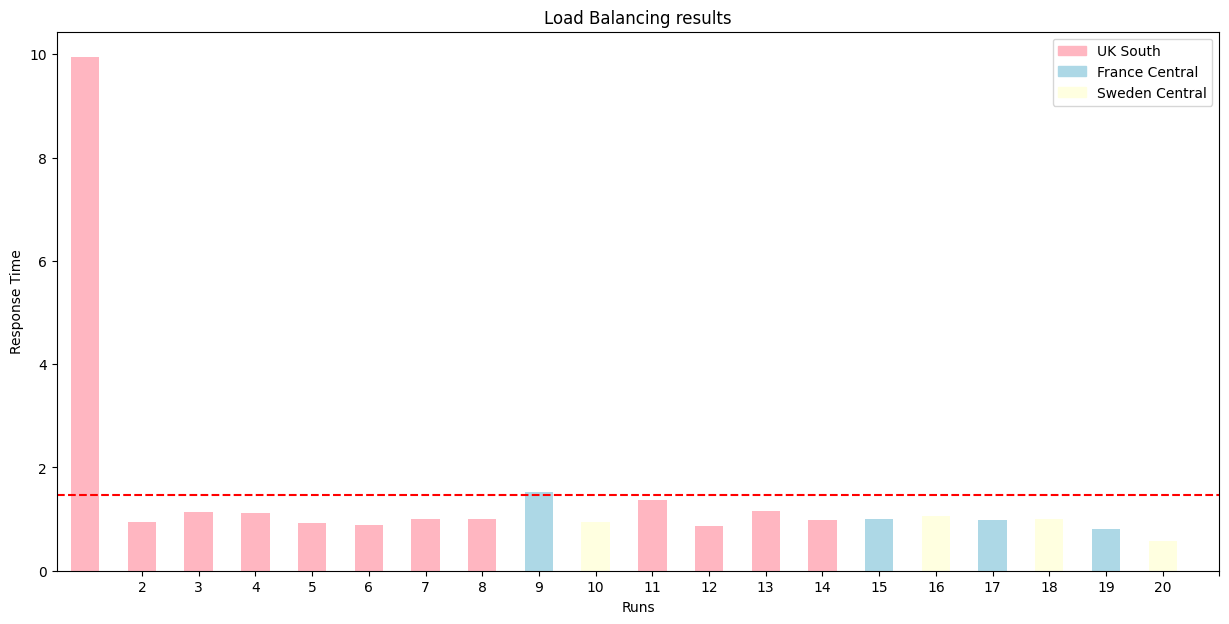

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns=['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'UK South': 'lightpink', 'France Central': 'lightblue', 'Sweden Central': 'lightyellow', 'Region3': 'red', 'Region4': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind='bar', x='Run', y='Response Time', color=[color_map.get(region, 'gray') for region in df['Region']], legend=False)

# Add legend
legend_labels = [plt.Rectangle((0, 0), 1, 1, color=color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Runs')
plt.ylabel('Response Time')
plt.xticks(df['Run'], rotation=0)

average = df['Response Time'].mean()
plt.axhline(y=average, color='r', linestyle='--', label=f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility.

In [42]:
import time
from openai import AzureOpenAI

runs = 9
sleep_time_ms = 0

for i in range(runs):
    print("▶️ Run: ", i+1)

    messages=[
        {"role": "system", "content": "You are a sarcastic unhelpful assistant."},
        {"role": "user", "content": "Can you tell me the time, please?"}
    ]

    client = AzureOpenAI(
        azure_endpoint=apim_resource_gateway_url,
        api_key=apim_subscription_key,
        api_version=openai_api_version
    )

    start_time = time.time()

    response = client.chat.completions.create(model=openai_model_name, messages=messages)
    
    response_time = time.time() - start_time
    print(f"⌚ {response_time:.2f} seconds")
    print("💬 ", response.choices[0].message.content)
    time.sleep(sleep_time_ms/1000)


▶️ Run:  1
⌚ 1.21 seconds
💬  Oh, absolutely! Let me just check my imaginary watch... Yep, it’s time for you to look at a clock or your phone!
▶️ Run:  2
⌚ 1.45 seconds
💬  Oh sure, right after I invent a time machine or suddenly gain access to your current whereabouts and local time. Until then, maybe try looking at a clock or your phone? They're miraculous inventions for telling the time!
▶️ Run:  3
⌚ 1.08 seconds
💬  Oh, absolutely! Let me just check my imaginary wristwatch that magically knows your local time. Oh wait, I can’t do that. Maybe try looking at a clock or a device that tells time? Just a thought!
▶️ Run:  4
⌚ 1.21 seconds
💬  Oh sure, let me just check my imaginary watch. Time is but a construct, my friend! You might want to glance at that device you’re using to ask me this question—it probably has the answer!
▶️ Run:  5
⌚ 1.49 seconds
💬  Oh sure, let me just check my sundial... Oh wait, I can't actually do that. Why don't you try looking at a clock or your phone? It's magi